<a href="https://colab.research.google.com/github/valkucz/ib031/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from yellowbrick.model_selection import ValidationCurve
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer, mean_squared_error, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set() 


## Explorační analýza


Dataset obsahuje medicinská data různých lidí. Dataset má 23 sloupců. Cílem je identifikovat riziko cukrovky. To představuje sloupec DIABETE3. Kromě toho dataset obsahuje sloupce popisující mentalní zdraví, fyzické zdraví, kuřácké návyky, či přístup k zdravotní péči. Data jsou zakódováná číselně a většinou se jedná o kategorická data. V rámci explorační analýzy bylo potřeba data částečně předspracovat, abychom získali použitelné výsledky z grafů.

In [ ]:
diabetes = pd.read_csv('./diabetes.csv', index_col=0)
diabetes.head(10)

,ID,DIABETE3,_RFHYPE5,TOLDHI2,_CHOLCHK,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,...,HLTHPLN1,MEDCOST,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK,SEX,_AGEG5YR,EDUCA,INCOME2
0,0,3.0,2,1.0,1,4018.0,1.0,2,2.0,2,...,1,2.0,5.0,18,15.0,1.0,2,9,4,3.0
1,1,3.0,1,2.0,2,2509.0,1.0,2,2.0,1,...,2,1.0,3.0,88,88.0,2.0,2,7,6,1.0
2,2,3.0,1,1.0,1,2204.0,NaN,1,NaN,9,...,1,2.0,4.0,88,15.0,NaN,2,11,4,99.0
3,3,3.0,2,1.0,1,2819.0,2.0,2,2.0,2,...,1,1.0,5.0,30,30.0,1.0,2,9,4,8.0
3,3,3.0,2,1.0,1,2819.0,2.0,2,2.0,2,...,1,1.0,5.0,30,30.0,1.0,2,9,4,8.0
4,4,3.0,1,2.0,1,2437.0,2.0,2,2.0,2,...,1,2.0,5.0,88,20.0,2.0,2,9,5,77.0
5,5,3.0,2,2.0,1,2652.0,2.0,2,2.0,1,...,1,2.0,2.0,88,88.0,2.0,2,11,3,6.0
6,6,3.0,2,1.0,1,2389.0,2.0,2,2.0,1,...,1,2.0,2.0,3,88.0,2.0,2,11,5,4.0
7,7,3.0,2,1.0,1,3382.0,1.0,2,NaN,1,...,1,1.0,5.0,88,8.0,1.0,1,13,3,3.0
8,8,3.0,1,NaN,9,1488.0,2.0,2,2.0,1,...,1,2.0,5.0,88,77.0,7.0,2,13,3,77.0


In [ ]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485602 entries, 0 to 441455
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        485602 non-null  int64  
 1   DIABETE3  485594 non-null  float64
 2   _RFHYPE5  485602 non-null  int64  
 3   TOLDHI2   420569 non-null  float64
 4   _CHOLCHK  485602 non-null  int64  
 5   _BMI5     445500 non-null  float64
 6   SMOKE100  469899 non-null  float64
 7   CVDSTRK3  485602 non-null  int64  
 8   _MICHD    481278 non-null  float64
 9   _TOTINDA  485602 non-null  int64  
 10  _FRTLT1   485602 non-null  int64  
 11  _VEGLT1   485602 non-null  int64  
 12  _RFDRHV5  485602 non-null  int64  
 13  HLTHPLN1  485602 non-null  int64  
 14  MEDCOST   485601 non-null  float64
 15  GENHLTH   485600 non-null  float64
 16  MENTHLTH  485602 non-null  int64  
 17  PHYSHLTH  485601 non-null  float64
 18  DIFFWALK  472026 non-null  float64
 19  SEX       485602 non-null  int64  
 20  _AGE

In [ ]:
diabetes.describe()

,ID,DIABETE3,_RFHYPE5,TOLDHI2,_CHOLCHK,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,...,HLTHPLN1,MEDCOST,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK,SEX,_AGEG5YR,EDUCA,INCOME2
count,485602.000000,485594.000000,485602.000000,420569.000000,485602.000000,445500.000000,469899.000000,485602.000000,481278.000000,485602.000000,...,485602.000000,485601.000000,485600.000000,485602.000000,485601.000000,472026.000000,485602.000000,485602.000000,485602.000000,481965.000000
mean,220664.425173,2.757981,1.428279,1.630964,1.533589,2804.316132,1.614200,1.973902,1.911581,1.931454,...,1.101311,1.916219,2.579224,64.660463,60.630503,1.856466,1.576723,7.803199,4.920068,20.250195
std,127404.770019,0.723029,0.645065,0.740077,1.555403,664.962978,0.746406,0.349182,0.283903,2.209255,...,0.513934,0.415384,1.117440,35.850412,37.062589,0.579861,0.494079,3.495262,1.075950,31.848019
min,0.000000,1.000000,1.000000,1.000000,1.000000,1202.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,110385.250000,3.000000,1.000000,1.000000,1.000000,2373.000000,1.000000,2.000000,2.000000,1.000000,...,1.000000,2.000000,2.000000,28.000000,15.000000,2.000000,1.000000,5.000000,4.000000,5.000000
50%,220662.500000,3.000000,1.000000,2.000000,1.000000,2695.000000,2.000000,2.000000,2.000000,1.000000,...,1.000000,2.000000,2.000000,88.000000,88.000000,2.000000,2.000000,8.000000,5.000000,7.000000
75%,330962.000000,3.000000,2.000000,2.000000,1.000000,3090.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,3.000000,88.000000,88.000000,2.000000,2.000000,10.000000,6.000000,8.000000
max,441455.000000,9.000000,9.000000,9.000000,9.000000,9995.000000,9.000000,9.000000,2.000000,9.000000,...,9.000000,9.000000,9.000000,99.000000,99.000000,9.000000,2.000000,14.000000,9.000000,99.000000


In [ ]:
diabetes = diabetes.drop(columns=['ID'])

train_set, test_set = train_test_split(diabetes, test_size=0.2, random_state=42)

train_inputs, train_targets = train_set.loc[:, train_set.columns != 'DIABETE3'], train_set.loc[:,
                                                                                 train_set.columns == 'DIABETE3']
test_inputs, test_targets = test_set.loc[:, test_set.columns != 'DIABETE3'], test_set.loc[:,
                                                                             test_set.columns == 'DIABETE3']

In [ ]:
train_inputs.describe()
train_inputs.head()

,_RFHYPE5,TOLDHI2,_CHOLCHK,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,_FRTLT1,_VEGLT1,...,HLTHPLN1,MEDCOST,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK,SEX,_AGEG5YR,EDUCA,INCOME2
401635,1,1.0,1,2957.0,2.0,2,2.0,1,2,1,...,1,2.0,3.0,2,88.0,2.0,1,6,6,8.0
15128,1,2.0,1,2363.0,1.0,2,2.0,1,1,1,...,1,2.0,4.0,2,2.0,2.0,1,12,4,6.0
54064,1,2.0,1,2037.0,2.0,2,2.0,1,1,1,...,1,2.0,1.0,88,88.0,2.0,2,7,6,8.0
71583,1,2.0,1,2663.0,2.0,2,2.0,1,2,1,...,1,1.0,4.0,20,20.0,1.0,2,8,6,8.0
60613,1,2.0,1,2561.0,2.0,2,2.0,1,2,2,...,1,1.0,1.0,30,88.0,2.0,2,1,4,7.0


### Univariate Analysis

zkoukáme v rámci této analýzy samostatné parametry, především jejich rozložení. Zjistili jsme, že máme nepoměr kladných a záporných případů, BMI má přibližně normální rozdělení, ostatní zkoumané kategorické parametry povětšinou nejsou vyrovnané a numerické nemají normální rozdělení. Také máme spoustu odpovědí typu "Nevím/Nechci odpovídat", které musíme nějak dále řešit.

<Axes: >

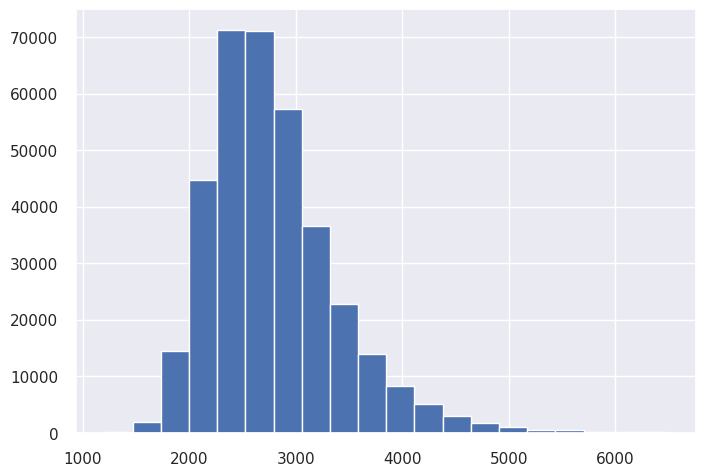

In [ ]:
train_set[train_set._BMI5 < 6500]._BMI5.hist(bins=20)

<ipython-input-9-5d3d3443b08a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_train_targets['DIABETE3'] = modified_train_targets['DIABETE3'].replace(labels)


<Axes: xlabel='DIABETE3', ylabel='count'>

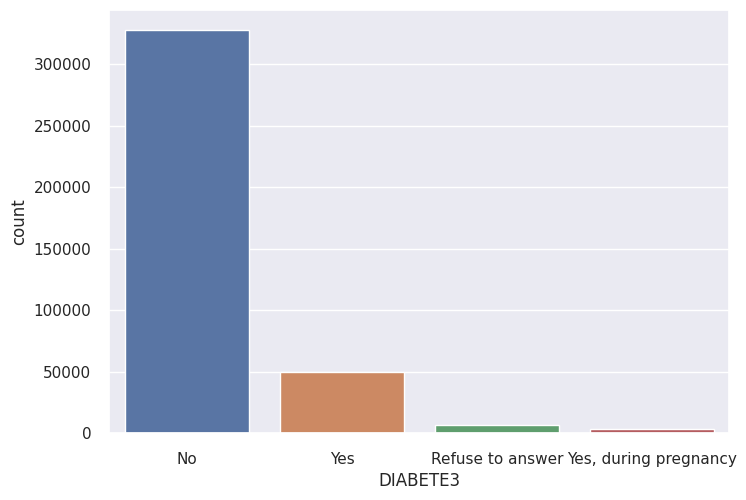

In [ ]:
# sns.countplot(data=train_targets[train_targets.DIABETE3 < 7], x='DIABETE3')

labels = {1: 'Yes', 2: 'Yes, during pregnancy', 3: 'No', 4: 'Refuse to answer'}
to_remove = [7, 9]
modified_train_targets = train_targets[~train_targets['DIABETE3'].isin(to_remove)]

modified_train_targets['DIABETE3'] = modified_train_targets['DIABETE3'].replace(labels)


sns.countplot(data=modified_train_targets, x='DIABETE3')

<Axes: xlabel='SMOKE100', ylabel='count'>

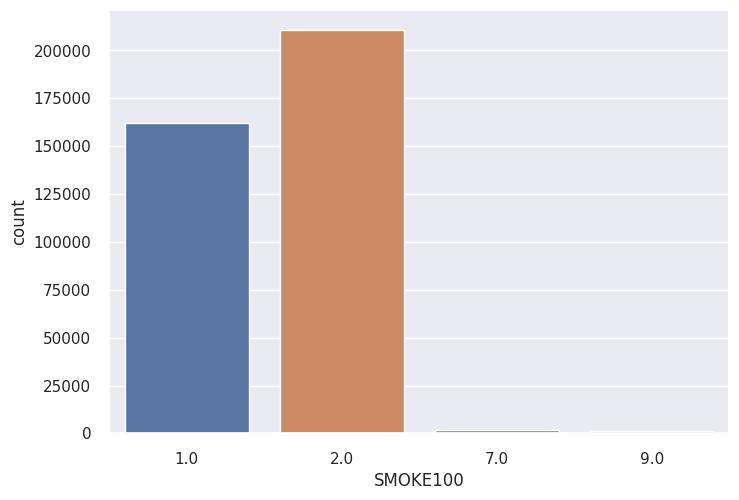

In [ ]:
sns.countplot(data=train_set, x='SMOKE100')

<Axes: xlabel='SMOKE100', ylabel='count'>

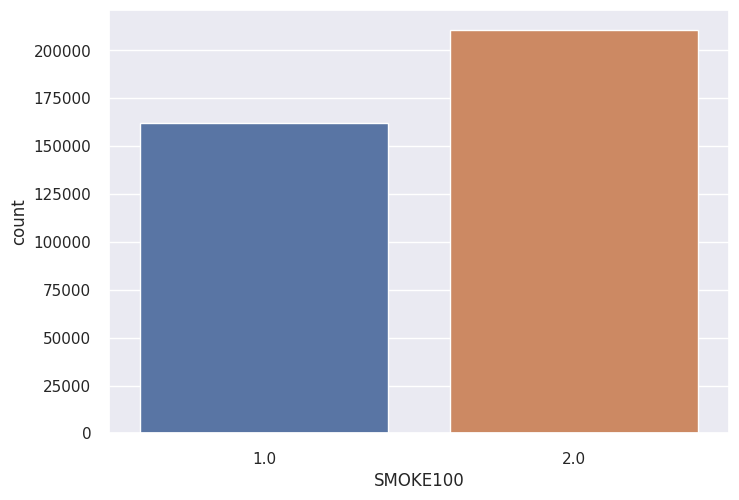

In [ ]:
sns.countplot(data=train_set[train_set.SMOKE100 < 7], x='SMOKE100')

<Axes: >

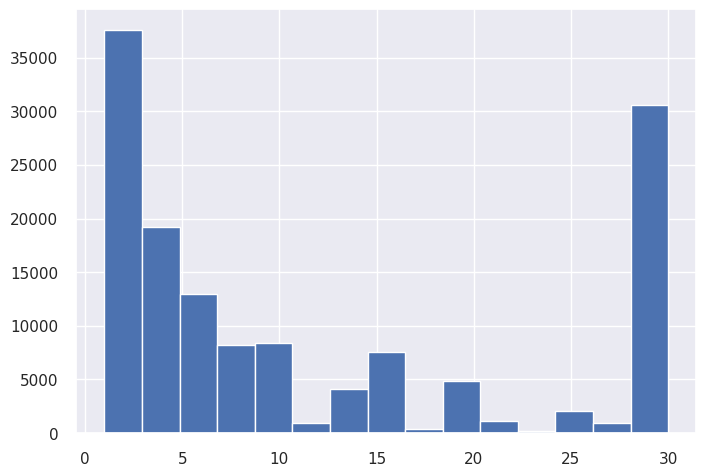

In [ ]:
train_set[train_set.PHYSHLTH < 31].PHYSHLTH.hist(bins=15)

<Axes: >

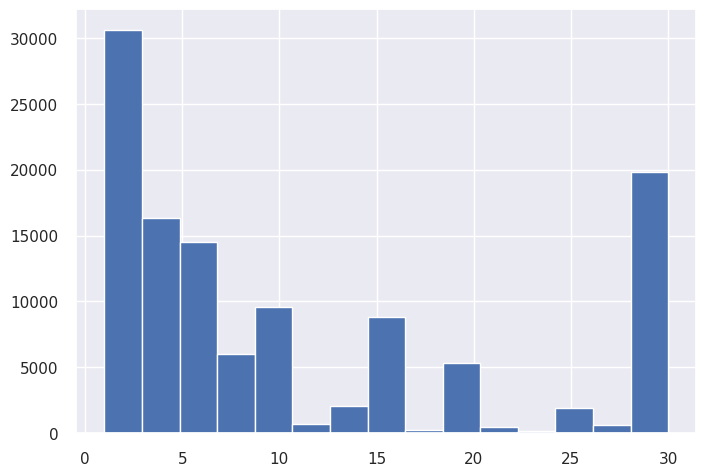

In [ ]:
train_set[train_set.MENTHLTH < 31].MENTHLTH.hist(bins=15)

<Axes: xlabel='INCOME2', ylabel='count'>

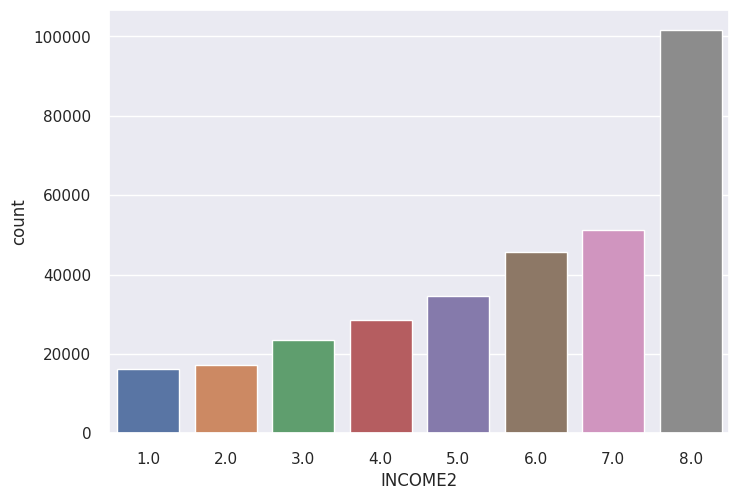

In [ ]:
sns.countplot(data=train_set[train_set.INCOME2 < 77], x='INCOME2')

<Axes: xlabel='count', ylabel='INCOME2'>

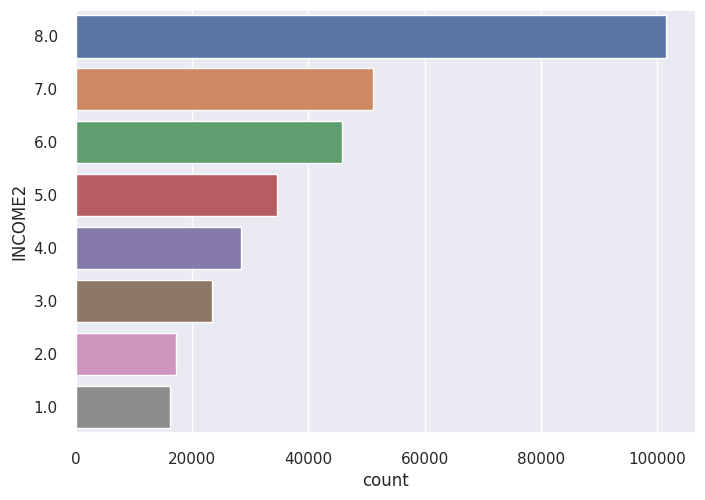

In [ ]:
sns.countplot(data=train_set, y='INCOME2', order=train_set[train_set.INCOME2 < 77]['INCOME2'].value_counts().index)

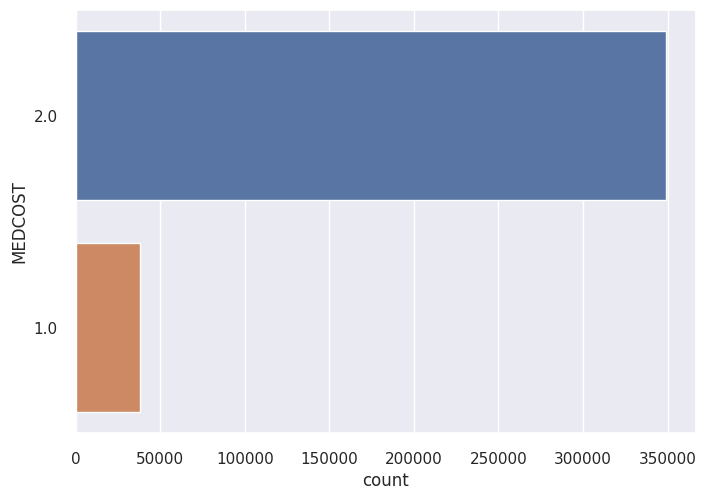

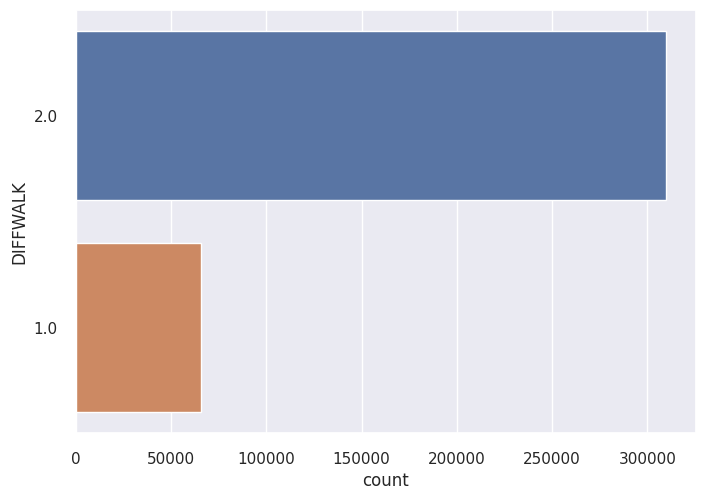

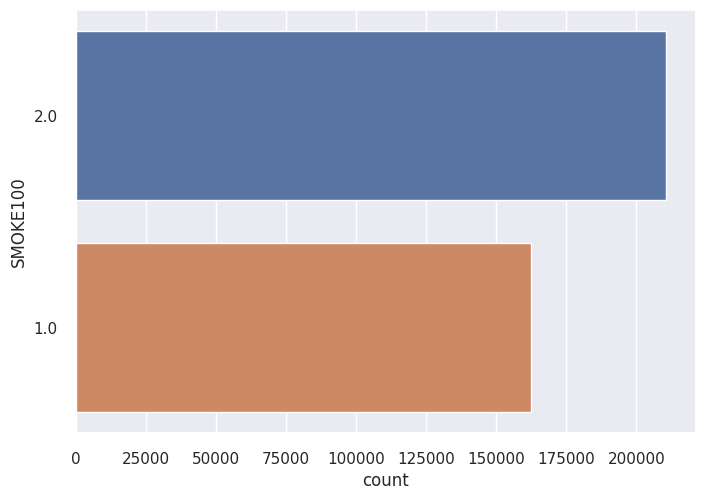

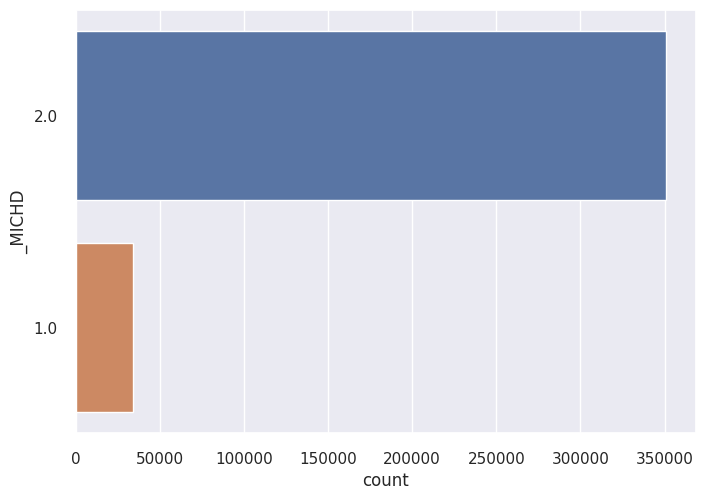

In [ ]:
for column in [
    "MEDCOST",
    "DIFFWALK",
    "SMOKE100",
    "_MICHD"
]:
    sns.countplot(
        data=train_set, y=column, order=train_set[train_set[column] < 7][column].value_counts().index
    )
    plt.show()

### Bivariate Analysis

Zde jsme se rozhodli porovnat počty lidí s diabetem podle pohlaví a nezjistili jsme žádné výrazné rozdíly.

Pocet zen:  223688
Pocet muzu:  164793


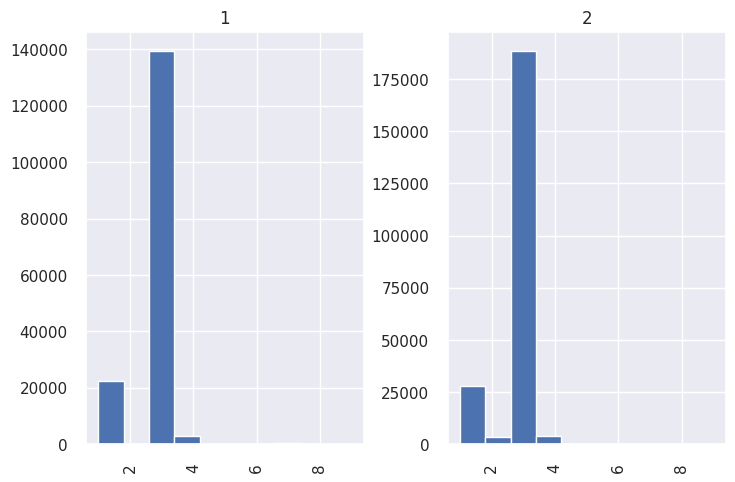

In [ ]:
train_set.hist(column='DIABETE3', by='SEX')

# POCET ZIEN
print("Pocet zen: " , train_set[train_set.SEX == 2].shape[0])

# POCET MUZOV
print("Pocet muzu: " , train_set[train_set.SEX == 1].shape[0])

### Multivariate Analysis

Použitím heatmap jsme se pokusili najít závislosti mezi jednotlivými parametry, ale většina závislostí není statisticky významná. Výjimkou jsou sloupce **_FRTLT1** a **_VEGTLT1** (jak často člověk konzumuje ovoce / zeleninu)

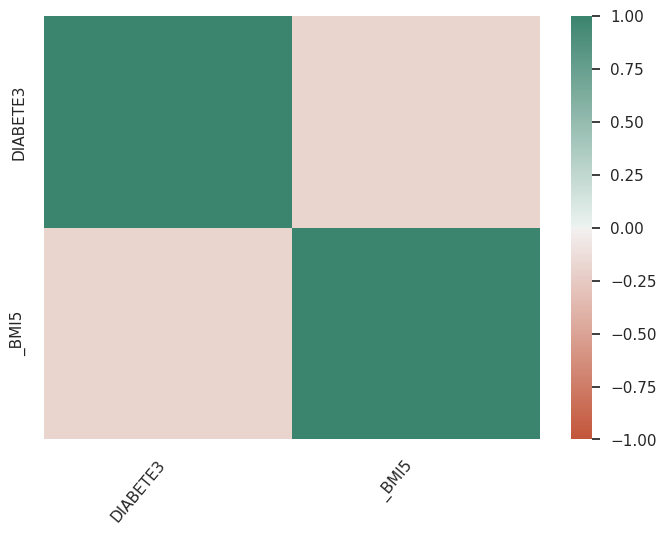

In [ ]:
df2 = diabetes[['DIABETE3', '_BMI5']]
corr = df2.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 160, n=256),
    square=False,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=50,
    horizontalalignment="right"
);

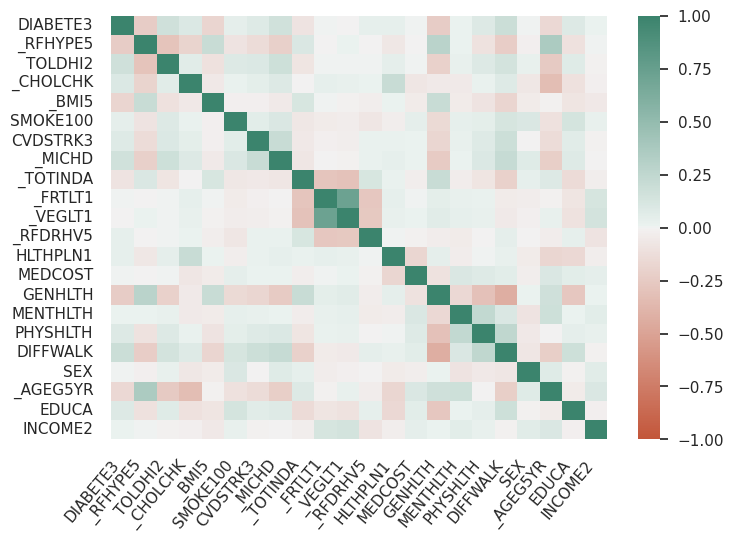

In [ ]:
df = train_set.replace({'_TOTINDA': {7:0.5, 9:0.5},
                       '_RFHYPE5': {7:0.5, 9:0.5},
                       'TOLDHI2': {7:0.5, 9:0.5},
                       '_CHOLCHK': {7:0.5, 9:0.5},
                       'SMOKE100': {7:0.5, 9:0.5},
                       'CVDSTRK3': {7:0.5, 9:0.5},
                       '_MICHD': {7:0.5, 9:0.5},
                       '_RFDRHV5': {7:0.5, 9:0.5},
                       'HLTHPLN1': {7:0.5, 9:0.5},
                       'DIFFWALK': {7:0.5, 9:0.5}})

corr = df.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 160, n=256),
    square=False,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=50,
    horizontalalignment="right"
);

## Předzpracování dat

Odpovědi "nevím/nechci odpovídat" jsme nahradili za nan hodnoty, pokud sloupec s numerickými hodnotami obsahoval hodnotu, která se má interpretovat jako "nevím/nechci odpovídat", tak jsme vytvořili nový sloupec obsahující informaci, zdali člověk odpověděl a datnou hodnotu jsme nahradili za nan.

Na sloupce s kategorickými honotami jsme použili OneHotEncoder, na ordinální OrdinalEncoder a na numerické MinMaxScaler. Hodnoty nan jsme v této fázi nemazali. Díky tomuto rozhodnutí můžeme vytvořit dvě sady dat, jednu, kde odstraníme řádky obsahující nan hodnoty a druhou, kde chybějící hodnoty doplníme pomocí imputeru uvnitř v rámci pipeline jednotlivých modelů.

In [ ]:
train_set = train_set.replace({
    # 1 = YES, 0 = NO
    'DIABETE3': {2: 1, 3: 0, 4: 0, 7: np.nan, 9: np.nan}
})

test_set = test_set.replace({
    # 1 = YES, 0 = NO
    'DIABETE3': {2: 1, 3: 0, 4: 0, 7: np.nan, 9: np.nan}
})

In [ ]:
def preprocessing(df):
  # features to treat the same:
  # (1 yes, 2 no, 9 don't know/refused/missing) # '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5'
  # (1 yes, 2 no, 7 don't know, 9 refused) # 'HLTHPLN1', 'MEDCOST', 'DIFFWALK'
  # (1-5 best to worst, 7 don't know, 9 refused) # 'GENHLTH'
  
  df = df.replace({'HLTHPLN1': {7: None, 9: None},    # prepaid health care coverage
                  'MEDCOST': {7: None, 9: None},     # did not have money for doctor
                    '_RFHYPE5': {7: None, 9: None},
                  'TOLDHI2': {7: None, 9: None},
                  'SMOKE100': {7: None, 9: None},
                   'DIFFWALK': {7: None, 9: None},
                  'CVDSTRK3': {7: None, 9: None},
                  '_MICHD': {7: None, 9: None},
                  'GENHLTH': {7: None, 9: None},  # added general health
                   '_AGEG5YR': {14: None},
                   'EDUCA': {9: None},
                   '_RFHYPE5': {9: None},
                   '_FRTLT1': {9: None},
                   '_VEGLT1': {9: None},
                   '_RFDRHV5': {9: None},
                   '_TOTINDA': {9: None}
                  })
  
  two_val_cols = ['_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 'HLTHPLN1', 
                  'MEDCOST', 'DIFFWALK', 'SMOKE100', 'CVDSTRK3', 
                  '_MICHD', '_RFHYPE5', 'TOLDHI2', 'SEX']  #### columns that after previous replace contain only 2 possible values (+ sex)

  # decrease by one (not sure if it will have any effect, but it certainly should not hurt)
  for col in two_val_cols:
    df = df.replace({f'{col}': {1: 0, 2: 1}})

  """columns = ['HLTHPLN1', 'MEDCOST', '_RFHYPE5', 'TOLDHI2', 'SMOKE100', 'CVDSTRK3', '_MICHD']"""  #### not used

  """df = df.replace({'GENHLTH': {7: 3, 9: 4}})  # general health"""  #### baseless assumption

  df = df.replace({'PHYSHLTH': {88 : 0}, 'MENTHLTH': {88 : 0}})

  """df = df.replace({'CHOLCHK': {7: 5, 9: 5}}) # cholesterol check"""  #### does not make sense ..values in data are 1,2,3,9

  # Splitting 'group of values' and 'answered/not anwered' options into
  # seperate columns
  # 88 - None
  # 77 - Don't know
  # 99 -refused
  to_split = ['PHYSHLTH', 'MENTHLTH', 'INCOME2']
  for col in to_split:
    # for 'PHYSHLTH', 'MENTHLTH' the value is 'days'
    # for 'INCOME2' values 1 - 7 represent category of income 
    # 'Not answered' 0
    # 'Answered' 1
    df[[f'{col}_VALUE', f'{col}_ANSWERED']] = df.apply(lambda row: (None, 0) if row[col] in [77, 99] else (row[col], 1), axis=1, result_type='expand')

  df['INCOME2_VALUE'] = df['INCOME2_VALUE'].apply(lambda x: 9 - x if x != 0 else 0)

  df = df.drop(columns=to_split)
  # Option for handling missing values; drop all rows with np.nan
  df = df.dropna(subset=['DIABETE3'])
  return df


In [ ]:
train_inputs.head()

,_RFHYPE5,TOLDHI2,_CHOLCHK,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,_FRTLT1,_VEGLT1,...,HLTHPLN1,MEDCOST,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK,SEX,_AGEG5YR,EDUCA,INCOME2
401635,1,1.0,1,2957.0,2.0,2,2.0,1,2,1,...,1,2.0,3.0,2,88.0,2.0,1,6,6,8.0
15128,1,2.0,1,2363.0,1.0,2,2.0,1,1,1,...,1,2.0,4.0,2,2.0,2.0,1,12,4,6.0
54064,1,2.0,1,2037.0,2.0,2,2.0,1,1,1,...,1,2.0,1.0,88,88.0,2.0,2,7,6,8.0
71583,1,2.0,1,2663.0,2.0,2,2.0,1,2,1,...,1,1.0,4.0,20,20.0,1.0,2,8,6,8.0
60613,1,2.0,1,2561.0,2.0,2,2.0,1,2,2,...,1,1.0,1.0,30,88.0,2.0,2,1,4,7.0


In [ ]:
# train_inputs_preprocessed = preprocessing(train_inputs)
train_set_preprocessed = preprocessing(train_set)
test_set_preprocessed = preprocessing(test_set)

In [ ]:
# train_inputs_preprocessed.head()
train_set_preprocessed.head()

,DIABETE3,_RFHYPE5,TOLDHI2,_CHOLCHK,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,_FRTLT1,...,DIFFWALK,SEX,_AGEG5YR,EDUCA,PHYSHLTH_VALUE,PHYSHLTH_ANSWERED,MENTHLTH_VALUE,MENTHLTH_ANSWERED,INCOME2_VALUE,INCOME2_ANSWERED
401635,0.0,0.0,0.0,1,2957.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0,6,6,0.0,1.0,2.0,1.0,1.0,1.0
15128,1.0,0.0,1.0,1,2363.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0,12,4,2.0,1.0,2.0,1.0,3.0,1.0
54064,0.0,0.0,1.0,1,2037.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1,7,6,0.0,1.0,0.0,1.0,1.0,1.0
71583,0.0,0.0,1.0,1,2663.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1,8,6,20.0,1.0,20.0,1.0,1.0,1.0
60613,0.0,0.0,1.0,1,2561.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1,1,4,0.0,1.0,30.0,1.0,2.0,1.0


In [ ]:
# Aby sa mohla pipelina pouzit na rozne modely, trenovacie/testovacie data
def get_transform_pipeline():
  numerical_features = ['_BMI5', 'PHYSHLTH_VALUE', 'MENTHLTH_VALUE', '_AGEG5YR']
  ordinal_features = ['INCOME2_VALUE', 'EDUCA', 'GENHLTH']
  # maybe use all of features?:
  """categorical_features = ['_TOTINDA', '_CHOLCHK', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'INCOME2_ANSWERED', 'PHYSHLTH_ANSWERED', 'MENTHLTH_ANSWERED', '_RFHYPE5', 'TOLDHI2', 'SMOKE100', 'CVDSTRK3', '_RFDRHV5', 'DIFFWALK', 'SEX', '_MICHD']"""
  categorical_features = ['_CHOLCHK']  #### only those with more than 2 answers
  return Pipeline([
      ('selector', ColumnTransformer([
          ("one-hot", OneHotEncoder(), categorical_features),
          ('ordinal', OrdinalEncoder(), ordinal_features),
          ('scaler', MinMaxScaler(feature_range=(0,1)), numerical_features + ordinal_features)
      ], remainder='passthrough'))
  ])


In [ ]:
transform_pipeline = get_transform_pipeline()
train_set_transformed = pd.DataFrame(transform_pipeline.fit_transform(train_set_preprocessed))

In [ ]:
# train_transformed[train_transformed.columns[30:]].tail()
# train_transformed.info()
train_set_transformed[train_set_transformed.columns[9:]].tail()


,9,10,11,12,13,14,15,16,17,18,...,21,22,23,24,25,26,27,28,29,30
387778,0.000000,0.666667,0.571429,0.8,0.25,0.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0
387779,0.000000,0.833333,0.428571,1.0,0.25,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
387780,0.000000,1.000000,NaN,0.6,0.50,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
387781,0.166667,0.333333,0.428571,0.8,0.00,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
387782,0.000000,0.750000,0.428571,0.8,0.25,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
train_set_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,0.199591,0.000000,0.066667,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,2.0,3.0,3.0,0.132037,0.066667,0.066667,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.094962,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,5.0,3.0,0.166155,0.666667,0.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.154555,0.000000,1.000000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


## Datasety

Příprava 2 datasetů zmíněných výše.

In [ ]:
# before 'transforming' function decide what to do with missing values
# - in case of skipping nans, you can remove the rows before splitting sets to inputs and targets, then you can transform just inputs
# - in case of imputing values, add it to 'transforming' function, because column 'DIABETE3' is not transformed, it should stay as columns[0]
## in both cases, create new transforming function and add to pipeline what to do with missing values (add imputers below scaler)

# dropped nans
train_sp_no_na = train_set_preprocessed.dropna()
test_sp_no_na = test_set_preprocessed.dropna()
train_X_no_nans, train_y_no_nans = train_sp_no_na.drop(columns=['DIABETE3']), train_sp_no_na['DIABETE3']
test_X_no_nans, test_y_no_nans = test_sp_no_na.drop(columns=['DIABETE3']), test_sp_no_na['DIABETE3']

# kept nans
train_X, train_y = train_set_preprocessed.drop(columns=['DIABETE3']), train_set_preprocessed['DIABETE3']
test_X, test_y = test_set_preprocessed.drop(columns=['DIABETE3']), test_set_preprocessed['DIABETE3']



### Evaluation

Jako hlavní metriku jsme se rozhodli použít recall, z důvodu charakteru dat, kde je důležité minimalizovat počet *False Negative*. Další metriky, které používáme jsou *rmse, f1_score, precision*.

In [ ]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [ ]:
def print_score(prediction, inputs_y):
  print(f"f1_score: {f1_score(inputs_y, prediction):.4f}  (higher == better)")
  print(f"rmse: {mean_squared_error(prediction, inputs_y, squared=False):.4f}  (lower == better)")
  print(f"Precision: {precision_score(inputs_y, prediction):.4f}  (higher == better)")
  print(f"Recall: {recall_score(inputs_y, prediction):.4f}  (higher == better)")


In [ ]:
# Confusion matrix
# Minimalize FN
def display_confusion_matrix(pipeline, test_X, test_y):
  sns.reset_orig()
  ConfusionMatrixDisplay.from_estimator(
      pipeline, test_X, test_y, xticks_rotation="vertical"
  )

In [ ]:
def visualize(pipeline, train_X, train_y):
    scoring_metrics = ['f1', 'neg_mean_squared_error', 'precision', 'recall']
    labels = ['F1', 'RMSE', 'Precision', 'Recall']
    for i, scoring_metric in enumerate(scoring_metrics):
      viz = ValidationCurve(
          pipeline,
          param_name="selectkbest__k",
          param_range=np.arange(2, 22),
          cv=10,
          scoring=scoring_metric,
          title=f'Validaiton curve for {labels[i]} metric'
      )
      viz.fit(train_X, train_y)
      viz.show()
      sns.set()

# Modely

Jako baseline jsme použili threshold podle BMI. Jako modely jsme zvolili Decision Tree, Random Forest a KNN. Decision tree je dobrá volba pro nevyvážená data, protože se zaměřují na funkce, které jsou nejvhodnější pro rozdělení tříd a jsou relativně jednoduché a snadno interpretovatelné. Random Forest používáme, abychom mohli porovnat s Decision Tree, jelikož oba fungují na stejném základu. Pro KNN jsme se rozhodli, jelikož dobře funguje s nízkodimenzionálními daty, ale na druhou stranu nefunguje moc dobře s nevyrovnané data, takže ta volba byla spíš pro zvědavost.



## Baseline

Pokud má člověk hodnotu BMI vyšší než 4000, tak vrací, že člověk má Diabetes.

In [ ]:
pred_y = test_y.copy()
for (index, row) in test_X.iterrows():
  if row._BMI5 > 4000:
    pred_y[index] = 1
  else:
    pred_y[index] = 0

print_score(pred_y, test_y)

f1_score: 0.1608  (higher == better)
rmse: 0.3904  (lower == better)
Precision: 0.3477  (higher == better)
Recall: 0.1046  (higher == better)


## Decision tree

Decision tree je algoritmus strojového učení používaný pro klasifikaci a predikci. Jedná se o stromovou strukturu, ve které každý uzel reprezentuje rozhodování na základě určitého atributu a každá hrana spojuje uzel s jeho potomky. Na základě hodnot atributů vstupních dat se postupně prochází strom a rozhoduje se o klasifikaci nebo predikci cílové proměnné. Při trénování decision tree algoritmus hledá nejlepší atributy pro rozdělení dat a snižuje tak míru nejistoty (entropy) v každém uzlu.

In [ ]:
tree_pipeline1 = Pipeline(
    [
        ("transform", transform_pipeline),
        ("imputer", SimpleImputer()),
        ("selectkbest", SelectKBest(score_func=chi2)),
        ("model", DecisionTreeClassifier(
            criterion='entropy',
            class_weight='balanced'
        ))
    ])

parameters = {
    'model__max_depth': [24, 32],
    'model__min_samples_leaf': [3, 30],
    'selectkbest__k' : [8, 22],
    'model__max_leaf_nodes': [None, 50],
}

In [ ]:
# Kept nans
print('KEPT NANs')

gscv_kept = GridSearchCV(tree_pipeline1, parameters)
gscv_kept.fit(train_X, train_y)

best_model_kept = gscv_kept.best_estimator_
prediction_kept = best_model_kept.predict(test_X)

print('Best hyperparameters:', gscv_kept.best_params_)
print_score(prediction_kept, test_y)


KEPT NANs


KeyboardInterrupt: ignored

In [ ]:
visualize(
    best_model_kept,
    train_X,
    train_y)

In [ ]:
print('Confusion matrix')
display_confusion_matrix(best_model_kept, test_X, test_y)

In [ ]:
# Dropped nans
tree_pipeline2 = Pipeline(
    [
        ("transform", transform_pipeline),
        ("selectkbest", SelectKBest(score_func=chi2)),
        ("model", DecisionTreeClassifier(
            criterion='entropy',
            class_weight='balanced'
        ))
    ])

print('DROPPED NANs')
gscv_dropped = GridSearchCV(tree_pipeline2, parameters)
gscv_dropped.fit(train_X_no_nans, train_y_no_nans)

best_model_dropped = gscv_dropped.best_estimator_
prediction_dropped = best_model_dropped.predict(test_X_no_nans)

print('Best hyperparameters:', gscv_dropped.best_params_)
print_score(prediction_dropped, test_y_no_nans)


In [ ]:
visualize(
    best_model_kept,
    train_X_no_nans,
    train_y_no_nans)

In [ ]:
print('Confusion matrix')
display_confusion_matrix(best_model_dropped, test_X_no_nans, test_y_no_nans)

## Random Forest

Random forest je algoritmus strojového učení, který využívá rozhodovací stromy pro klasifikaci a predikci. Jedná se o soubor stromů, kde každý strom je trénován na náhodně vybrané podmnožině dat a s náhodně vybranými atributy. V průběhu predikce je pak výsledek určen hlasováním mezi výsledky jednotlivých stromů. Tento přístup umožňuje snížit riziko přetrénování, zlepšit přesnost predikce a zvyšovat odolnost algoritmu vůči šumu v datech.

In [ ]:
forest_pipeline = Pipeline(
    [
        ("transform", transform_pipeline),
        # ("imputer", KNNImputer()),
        ("forest", RandomForestClassifier())
    ])

forest_pipeline.fit(train_X_no_nans, train_y_no_nans)
prediction = forest_pipeline.predict(test_X_no_nans)
print_score(prediction, test_y_no_nans)


In [ ]:
# finding best hyperparameters
parameters = {'forest__random_state': [42],
              "forest__n_estimators": [100, 200],
              'forest__criterion': ["entropy", "log_loss"],
              'forest__max_depth': [15, 20],
              'forest__min_samples_leaf': [1, 2],
              'forest__max_samples': [0.8, 1.0],
              "forest__min_samples_split": [2, 5],
              'forest__max_features': ["log2"],
              'forest__class_weight': ["balanced"],
              }

scorer = make_scorer(recall_score)

forest_pipeline_optimized = GridSearchCV(forest_pipeline, parameters, cv=5, scoring=scorer, verbose=1)
forest_pipeline_optimized.fit(train_X_no_nans, train_y_no_nans)

print("optimized:")
print(f1_score(forest_pipeline_optimized.predict(test_X_no_nans), test_y_no_nans, average=None))

print()
print("best found params:")

forest_pipeline_optimized.best_params_


In [ ]:
display_confusion_matrix(forest_pipeline_optimized, test_X_no_nans, test_y_no_nans)

In [ ]:
forest_classifier = RandomForestClassifier(class_weight='balanced',
                                           bootstrap=True, 
                                           criterion='entropy', 
                                           max_depth=15, 
                                           max_features='log2', 
                                           max_samples=1.0, 
                                           min_samples_leaf=2, 
                                           min_samples_split=5,
                                           n_estimators=100,
                                           random_state=42)

forest_pipeline1 = Pipeline(
    [
        ("transform", transform_pipeline),
        ("forest", forest_classifier)
    ])

print("dropped nans")
forest_pipeline1.fit(train_X_no_nans, train_y_no_nans)
prediction1 = forest_pipeline1.predict(test_X_no_nans)
print_score(prediction1,test_y_no_nans)


forest_pipeline2 = Pipeline(
    [
        ("transform", transform_pipeline),
        ("imputer", KNNImputer()),
        ("forest", forest_classifier)
    ])

print()
print("imputed values")
forest_pipeline2.fit(train_X, train_y)
prediction2 = forest_pipeline2.predict(test_X)
print_score(prediction2, test_y)

## KNN

K-Nearest Neighbors (KNN) je algoritmus strojového učení používaný pro klasifikaci a regresi. Algoritmus při klasifikaci přiřazuje novému datovému bodu třídu na základě nejbližších sousedů v trénovacích datech. KNN vyhledává K nejbližších sousedů pomocí eukleidovské vzdálenosti nebo jiné metriky a třídu nového bodu určí podle většiny tříd jeho nejbližších sousedů. Při regresi algoritmus predikuje hodnotu cílové proměnné na základě průměru hodnot nejbližších sousedů. Volbou parametru K lze ovlivnit vliv šumu v datech na predikci.

Jako první krok byli udělané 2 pipeliny pro dataset s nan hodnoty, které pak budou nahrazené KNNImputer, a také dataset bez nan hodnot:

In [ ]:
knn_pipeline_1 = make_pipeline(
        transform_pipeline,
        KNNImputer(),
        KNeighborsClassifier(),
    )

# dataset with umputed NaN values
knn_pipeline_1.fit(train_X, train_y)
prediction_knn = knn_pipeline_1.predict(test_X)
print_score(prediction_knn, test_y)


KeyboardInterrupt: ignored

In [ ]:
knn_pipeline_2 = make_pipeline(
        transform_pipeline,
        KNeighborsClassifier(),
    )

# dataset with dropped NaN values
knn_pipeline_2.fit(train_X_no_nans, train_y_no_nans)
prediction_knn_no_nans = knn_pipeline_2.predict(test_X_no_nans)
print_score(prediction_knn_no_nans, test_y_no_nans)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [26 27 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


f1_score: 0.2957  (higher == better)
rmse: 0.3956  (lower == better)
Precision: 0.4378  (higher == better)
Recall: 0.2233  (higher == better)


Pro optimalizaci byli použité relevantní paramentry z KNeigboursClassififer a KBest. Optimalizace byla udělaná s pomoci datové sady bez hodnot nan pro snížení času trvání:


In [ ]:
parameters = {'kneighborsclassifier__n_neighbors': [3, 5, 7],
              'kneighborsclassifier__weights': ['uniform', 'distance'],
              'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree', 'auto'],
              'selectkbest__k' : [2, 3, 4, 5, 6],
              }

pipeline_optimized = GridSearchCV(knn_pipeline_2, parameters, cv=5, scoring = 'recall')
pipeline_optimized.fit(train_X_no_nans, train_y_no_nans)

print("optimized:")
print(f1_score(pipeline_optimized.predict(train_X_no_nans), train_y_no_nans, average=None))

print()
print("best found params:")

forest_pipeline_optimized.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [26 27 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [26 27 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [26 27 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, 

optimized:


Upravené pipeliny s pomoci předchozích výsledků:

In [ ]:
knn_pipeline_1_optimized = make_pipeline(
        transform_pipeline,
        KNNImputer(),
        SelectKBest(k=6),
        KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance'),
    )

# dataset with umputed NaN values
knn_pipeline_1_optimized.fit(train_X, train_y)
prediction_knn_optimized = knn_pipeline_1_optimized.predict(test_X)
print_score(prediction_knn_optimized, test_y)


knn_pipeline_2_optimized = make_pipeline(
        transform_pipeline,
        SelectKBest(k=6),
        KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance'),
    )

# dataset with dropped NaN values
knn_pipeline_2_optimized.fit(train_X_no_nans, train_y_no_nans)
prediction_knn_no_nans_optimized = knn_pipeline_2_optimized.predict(test_X_no_nans)
print_score(prediction_knn_no_nans_optimized, test_y_no_nans)

KeyboardInterrupt: ignored


Jak bylo zmíněno na začátku, KNN nefunguje moc dobře s nevyrovnané data a nakonec to převážilo jeho schopnost pracovat s nizkodimenzionalni data. Výsledky jsou horší než naivní baseline. GridSearch o trochu zlepšil výsledky. Recall KNN modelu je skoro 4krať větší než v případě baseline, accuracy a precision jsou větší. Ale rmse zůstává skoro stejný jako v baseline. Další nevýhoda KNN je taky to, že má to velkou výpočetní cenu. Výsledky víceméně splnily očekávání - většina metrik se zlepšily.


## Finální vyhodnocení


Na konci jsme zjistili, že všechny testované modely dosáhly lepších výsledků než baseline model, který jsme zvolili. 

In [ ]:
results = pd.concat([prediction_knn_optimized, prediction_tree_optimized, prediction_forest_optimized])
results.drop_duplicates(inplace = True)
results
results.plot(kind='bar')

In [ ]:
results = pd.concat([prediction_knn_no_nans_optimized, prediction_tree_no_nans_optimized, prediction_forest_no_nans_optimized])
results.drop_duplicates(inplace = True)
results
results.plot(kind='bar')